# Demo 9 - Muscle synergies, part II

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('../signals/D08_signal.csv').values
W = pd.read_csv('../signals/D09_W.csv').values
angle = pd.read_csv('../signals/D08_angle.csv').values

print(data.shape)
print(W.shape)

n_muscles = data.shape[1]

(88827, 8)
(8, 4)


## Visualize raw emg

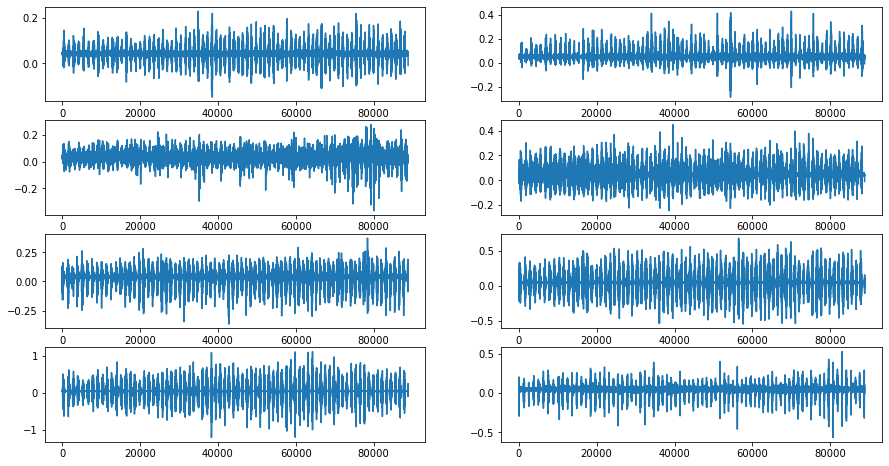

In [63]:
fig, ax = plt.subplots(4, 2, figsize=(15,8))
for i in range(n_muscles):
    row = int(np.floor(i/2))
    col = i % 2
    ax[row, col].plot(data[:,i])
plt.show()

## Filter EMG

In [64]:
from scipy.signal import butter, filtfilt

bp = [25, 450]
fs = 1000

b, a = butter(3, [x/fs for x in bp], btype='bandpass')

data_filt = filtfilt(b, a, data, axis=0)

In [65]:
bs = [49.5, 50.5]

b, a = butter(3, [x/fs for x in bs], btype='bandstop')

data_filt = filtfilt(b, a, data_filt, axis=0)

## Calculate envelope

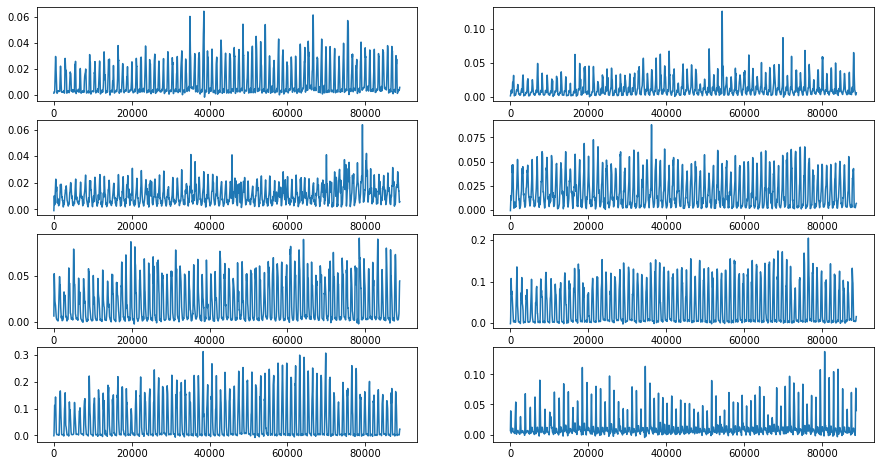

In [66]:
fc = 10
fs = 1000

b, a = butter(3, fc/fs, btype='lowpass')

env = filtfilt(b, a, np.abs(data_filt), axis=0)

fig, ax = plt.subplots(4, 2, figsize=(15,8))
for i in range(n_muscles):
    row = int(np.floor(i/2))
    col = i % 2
    ax[row, col].plot(env[:,i])
plt.show()

env = np.abs(env)

## Normalize envelope

In [67]:
from scipy.signal import find_peaks

pk_locs = find_peaks(angle.squeeze(), height= 5, distance = 500)[0]
pk_locs = pk_locs[pk_locs > 5000]

pk_values = []
for i0, i1 in zip(pk_locs[:-1], pk_locs[1:]):
    pk_values.append(np.max(env[i0:i1,:], axis=0)) 
pk_values = np.asarray(pk_values)
norm_factors = np.median(pk_values, axis=0)
env_norm = np.asarray([env[:,i]/norm_factors[i] for i in range(n_muscles)]).transpose()

## Define VAF and reconstruction functions

In [68]:
def VAF(true_data, rec_data):

    return 1 - np.sum((true_data.flatten() - rec_data.flatten())**2)/np.sum(rec_data.flatten()**2)

def nnr(data_in, w_in, max_iter, tol):
    if data_in.shape[1]<data_in.shape[0]:
        data_in = data_in.transpose()
    if w_in.shape[0]<w_in.shape[1]:
        w_in = w_in.transpose()
    c = 0
    convergence = False
    err = []
    h = np.random.rand(w_in.shape[1], data_in.shape[1])
    while c<max_iter:
        num = w_in.transpose()@data_in
        den = w_in.transpose()@w_in@h
        h *= num/den
        err.append(np.sqrt(np.sum((data_in.flatten() - (w_in@h).flatten())**2)))

        if c>10:
            if np.abs(err[-10] - err[-1]) < tol:
                c=max_iter
                convergence = True
        c += 1

    if not convergence:
        print('Algorithm did not converge')
        
    return h

## Reconstruct synergies

In [69]:
max_iter = 2000
tol = 1e-6
h_rec = nnr(env, W, max_iter, tol)

vaf_rec = VAF(env.transpose(), W@h_rec)
print(f'Reconstruction VAF: {vaf_rec:.4f}')

Reconstruction VAF: 0.7556


## Get random threshold

In [70]:
n_random = 200
w_rand = W.copy()

vaf_rand = []
for i in range(n_random):
    np.random.shuffle(w_rand)
    h_rand = nnr(env, W, max_iter, tol)
    vaf_rand.append(VAF(env.transpose(), w_rand@h_rand))
vaf_rand = np.asarray(vaf_rand)
print(vaf_rand.shape)

(200,)


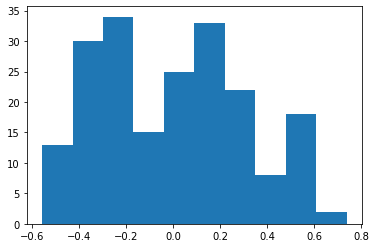

95th percentile: 0.5368


In [71]:
plt.figure()
plt.hist(vaf_rand)
plt.show()

print(f'95th percentile: {np.percentile(vaf_rand, 95):.4f}')